## Music generation project - separate models

Even though we use here 3 separate models for predicting notes, durations and offsets, code is very similar so I won't go through details which are explained in the other notebook.

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from music21 import *
import seaborn as sns
import tensorflow as tf
from tensorflow import keras 
import pandas as pd
from fractions import Fraction
import pickle

%matplotlib inline

### Preprocessing

In [52]:
filepaths = glob.glob('data/*.mid')

In [53]:
filepaths

['data\\Bach_-_Sonata_No._1_in_G_minor_-_BWV_1001_-_Presto.mid',
 'data\\Concerto_in_A_minor_A_Vivaldi.mid',
 'data\\Fur_Elise.mid',
 'data\\Solo_Violin_Caprice_No._24_in_A_Minor_-_N._Paganini_Op._1_No._24.mid',
 'data\\Solo_Violin_Partita_No._2_in_D_Minor_-_J._S._Bach_BWV_1004.mid',
 'data\\Solo_Violin_Partita_No._3_in_E_Major_-_J._S._Bach_BWV_1006.mid',
 'data\\Solo_Violin_Sonata_No._1_in_G_Minor_-_J._S._Bach_BWV_1001.mid',
 'data\\Solo_Violin_Sonata_No._2_in_A_Minor_-_J._S._Bach_BWV_1003.mid',
 'data\\Spring-Four_seasons_vivaldi.mid']

In [54]:
def read_parse_midi(file):
    midi = converter.parse(file)
    notes_to_parse = None
    notes = []
    durations = []
    offsets = []
    
    parts = instrument.partitionByInstrument(midi)

    for part in parts:
        if 'Violin' or 'StringInstrument' in str(part):
            notes_to_parse = part.recurse()
            for i in range(len(notes_to_parse)):
                if isinstance(notes_to_parse[i], note.Note):
                    notes.append(str(notes_to_parse[i].pitch))
                    durations.append(notes_to_parse[i].duration.quarterLength)
                    offsets.append(Fraction(notes_to_parse[i].offset) - Fraction(notes_to_parse[i - 1].offset))
                elif isinstance(notes_to_parse[i], chord.Chord):
                    notes.append('.'.join(str(n) for n in notes_to_parse[i].normalOrder))
                    durations.append(notes_to_parse[i].duration.quarterLength)
                    offsets.append(Fraction(notes_to_parse[i].offset) - Fraction(notes_to_parse[i - 1].offset))
                elif isinstance(notes_to_parse[i], note.Rest):
                    notes.append(notes_to_parse[i].name)
                    durations.append(notes_to_parse[i].duration.quarterLength)
                    offsets.append(Fraction(notes_to_parse[i].offset) - Fraction(notes_to_parse[i - 1].offset))
    return np.array(notes), np.array(durations), np.array(offsets)

In [55]:
notes, durations, offsets = read_parse_midi(filepaths[4])

In [59]:
print(notes[:10])
print(durations[:10])
print(offsets[:10])

['D4' 'rest' 'rest' 'rest' 'D4' 'D4' 'E4' 'F4' 'G4' 'A4']
[0.25 Fraction(22, 3) 232.75 Fraction(1793, 3) 0.0 0.75 0.25 0.25 0.25
 0.25]
[Fraction(0, 1) Fraction(0, 1) Fraction(0, 1) Fraction(0, 1)
 Fraction(0, 1) Fraction(0, 1) Fraction(3, 4) Fraction(1, 4)
 Fraction(1, 4) Fraction(1, 4)]


In [60]:
notes_durations_offsets = [read_parse_midi(file) for file in filepaths]

In [61]:
notes_full = [notes_durations_offsets[i][0] for i in range(len(notes_durations_offsets))]
durations_full = [notes_durations_offsets[i][1] for i in range(len(notes_durations_offsets))]
offsets_full = [notes_durations_offsets[i][2] for i in range(len(notes_durations_offsets))]

In [62]:
for i in notes_full:
    print(i.shape)

(1604,)
(2005,)
(589,)
(1634,)
(8006,)
(5054,)
(3890,)
(5740,)
(1101,)


In [63]:
all_notes = [element for notes in notes_full for element in notes] 
all_durations = [element for durations in durations_full for element in durations]
all_offsets = [element for offsets in offsets_full for element in offsets]
unique_notes = set(all_notes)
unique_durations = set(all_durations)
unique_offsets = set(all_offsets)

In [64]:
len(unique_offsets)

21

In [44]:
pickle.dump(unique_offsets, open('unique_offsets.pkl', 'wb'))

In [65]:
unique_offsets

{Fraction(0, 1),
 Fraction(1, 12),
 Fraction(1, 6),
 Fraction(1, 4),
 Fraction(1, 3),
 Fraction(5, 12),
 Fraction(1, 2),
 Fraction(2, 3),
 Fraction(3, 4),
 Fraction(5, 6),
 Fraction(11, 12),
 Fraction(1, 1),
 Fraction(5, 4),
 Fraction(3, 2),
 Fraction(7, 4),
 Fraction(23, 12),
 Fraction(2, 1),
 Fraction(9, 4),
 Fraction(11, 4),
 Fraction(3, 1),
 Fraction(4, 1)}

In [69]:
len(unique_durations)

203

In [45]:
pickle.dump(unique_durations, open('unique_durations.pkl', 'wb'))

In [68]:
unique_durations

{0.0,
 Fraction(1, 12),
 Fraction(1, 6),
 0.25,
 Fraction(1, 3),
 Fraction(5, 12),
 0.5,
 Fraction(7, 12),
 Fraction(2, 3),
 0.75,
 Fraction(5, 6),
 Fraction(11, 12),
 1.0,
 Fraction(13, 12),
 Fraction(7, 6),
 1.25,
 Fraction(4, 3),
 Fraction(17, 12),
 1.5,
 Fraction(19, 12),
 Fraction(5, 3),
 1.75,
 Fraction(11, 6),
 Fraction(23, 12),
 2.0,
 Fraction(25, 12),
 Fraction(13, 6),
 2.25,
 Fraction(7, 3),
 Fraction(29, 12),
 2.5,
 Fraction(31, 12),
 Fraction(8, 3),
 2.75,
 3.0,
 Fraction(37, 12),
 Fraction(19, 6),
 3.25,
 Fraction(10, 3),
 Fraction(41, 12),
 3.5,
 Fraction(11, 3),
 3.75,
 Fraction(23, 6),
 4.0,
 Fraction(49, 12),
 Fraction(25, 6),
 Fraction(13, 3),
 Fraction(53, 12),
 4.5,
 Fraction(55, 12),
 Fraction(14, 3),
 4.75,
 Fraction(29, 6),
 5.0,
 Fraction(61, 12),
 5.25,
 Fraction(16, 3),
 5.5,
 5.75,
 6.0,
 Fraction(19, 3),
 6.5,
 Fraction(20, 3),
 6.75,
 7.0,
 Fraction(85, 12),
 Fraction(22, 3),
 Fraction(89, 12),
 7.5,
 Fraction(23, 3),
 7.75,
 8.0,
 Fraction(97, 12),
 Fracti

In [70]:
len(unique_notes)

212

In [46]:
pickle.dump(unique_notes, open('unique_notes.pkl', 'wb'))

In [71]:
unique_notes

{'0',
 '0.2',
 '0.2.3',
 '0.2.5',
 '0.2.6',
 '0.2.7',
 '0.3',
 '0.3.6',
 '0.3.7',
 '0.4',
 '0.4.7',
 '0.5',
 '0.6',
 '1',
 '1.2',
 '1.2.6.9',
 '1.4',
 '1.4.7',
 '1.4.7.10',
 '1.4.7.9',
 '1.4.8',
 '1.5.8',
 '1.6',
 '1.7',
 '10.0',
 '10.0.3',
 '10.0.4',
 '10.1',
 '10.1.3',
 '10.1.4',
 '10.1.4.6',
 '10.2',
 '10.2.3',
 '10.2.4',
 '10.2.5',
 '11',
 '11.0',
 '11.0.4',
 '11.1',
 '11.1.4',
 '11.1.5',
 '11.2',
 '11.2.4',
 '11.2.4.7',
 '11.2.5',
 '11.2.5.7',
 '11.2.6',
 '11.3',
 '11.3.6',
 '11.4',
 '2',
 '2.3',
 '2.3.7',
 '2.4',
 '2.4.5.9',
 '2.4.7',
 '2.4.7.10',
 '2.4.8',
 '2.4.9',
 '2.5',
 '2.5.7',
 '2.5.7.10',
 '2.5.8',
 '2.5.8.10',
 '2.5.8.11',
 '2.5.9',
 '2.6',
 '2.6.7',
 '2.6.9',
 '2.7',
 '2.8',
 '3',
 '3.4',
 '3.4.8',
 '3.5',
 '3.5.10',
 '3.5.9',
 '3.5.9.10',
 '3.6',
 '3.6.9',
 '3.6.9.11',
 '3.7',
 '3.7.10',
 '3.7.8',
 '3.7.9',
 '3.8',
 '3.9',
 '4',
 '4.10',
 '4.5',
 '4.5.9.0',
 '4.6',
 '4.6.10',
 '4.6.11',
 '4.7',
 '4.7.10',
 '4.7.10.0',
 '4.7.11',
 '4.8',
 '4.8.11',
 '4.9',
 '5',
 '5.10

In [107]:
pd.Series(all_offsets).value_counts() * 100 / len(all_offsets)

1/4      58.842791
1/2      14.755427
0         9.691794
1/12      8.074807
1/6       4.115046
1         2.025453
1/3       0.951963
3/4       0.739290
3/2       0.428721
2         0.131654
5/12      0.094521
5/4       0.047261
11/12     0.033758
2/3       0.020255
3         0.016879
9/4       0.006752
11/4      0.006752
5/6       0.006752
4         0.003376
23/12     0.003376
7/4       0.003376
dtype: float64

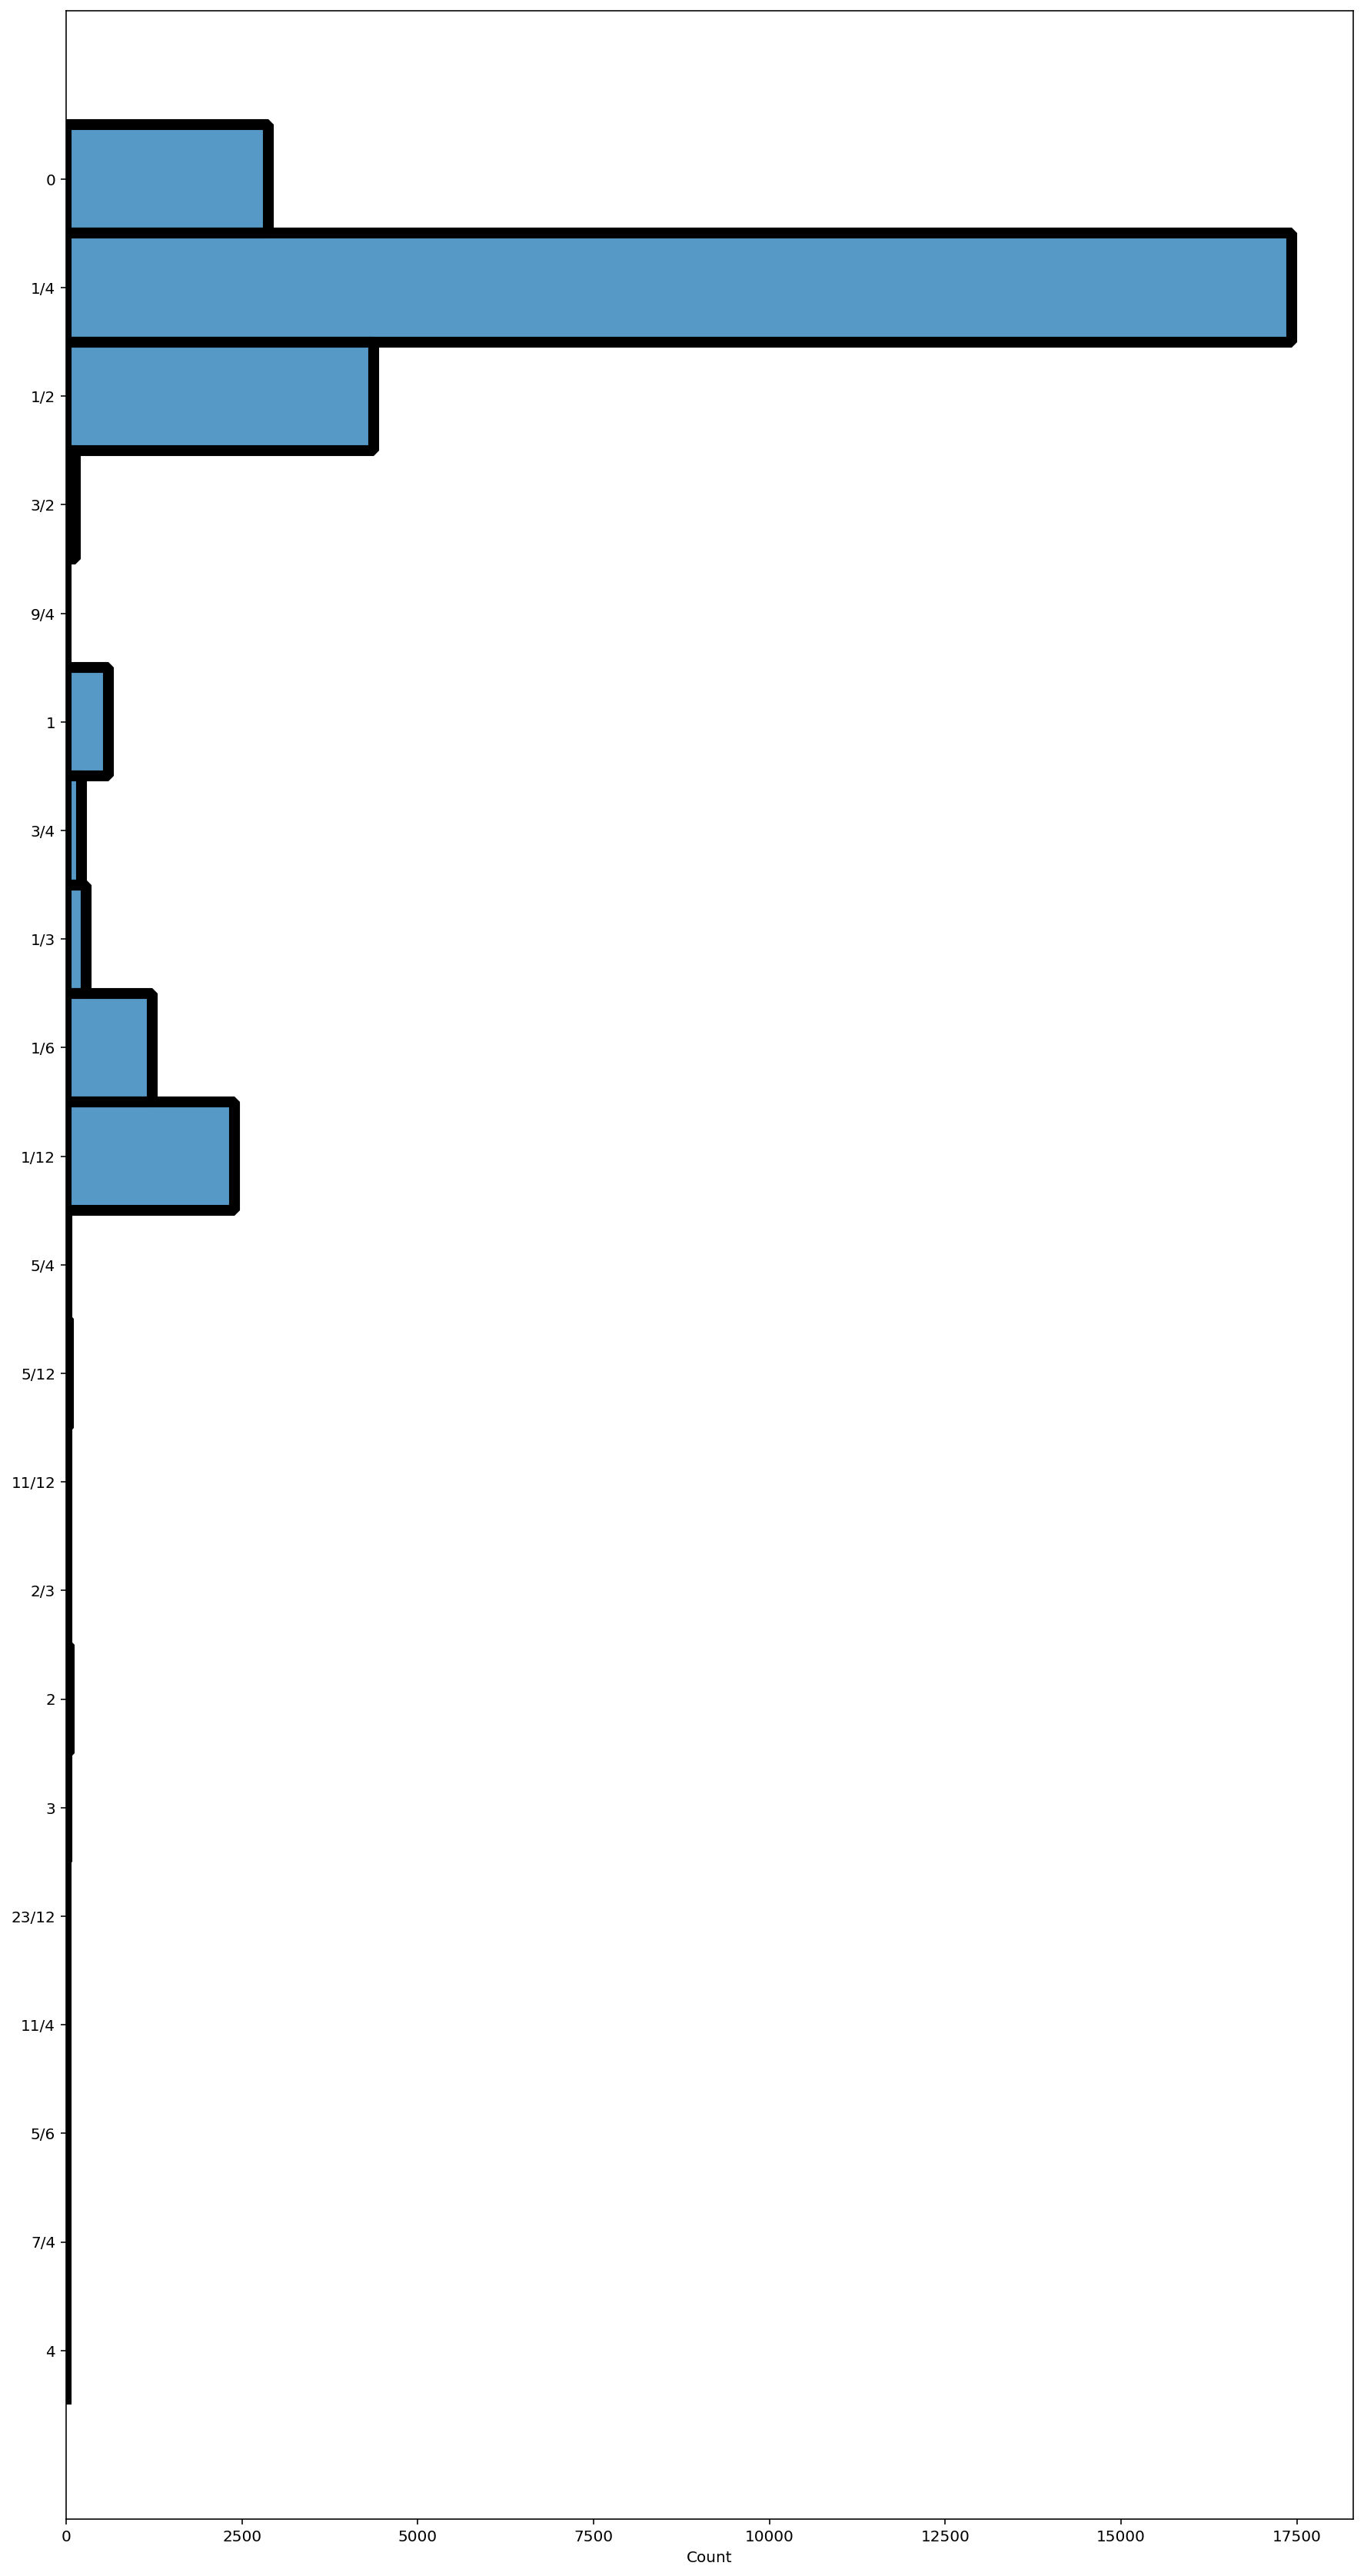

In [77]:
plt.figure(figsize=(15,30))
sns.histplot(y=[str(i) for i in all_offsets])

In [111]:
(pd.Series(all_durations).value_counts() * 100 / len(all_durations))[:20]

0.25     68.190258
0.5      16.301522
1.0       3.453398
1/3       2.788374
1/12      2.720859
0.75      1.390811
2/3       0.742666
1.5       0.671775
2.0       0.570503
5/12      0.411842
1/6       0.351079
1.75      0.199170
0.0       0.192418
3.0       0.168788
2.75      0.108024
13/12     0.087770
17/12     0.084394
2.5       0.084394
1.25      0.070891
4.0       0.070891
dtype: float64

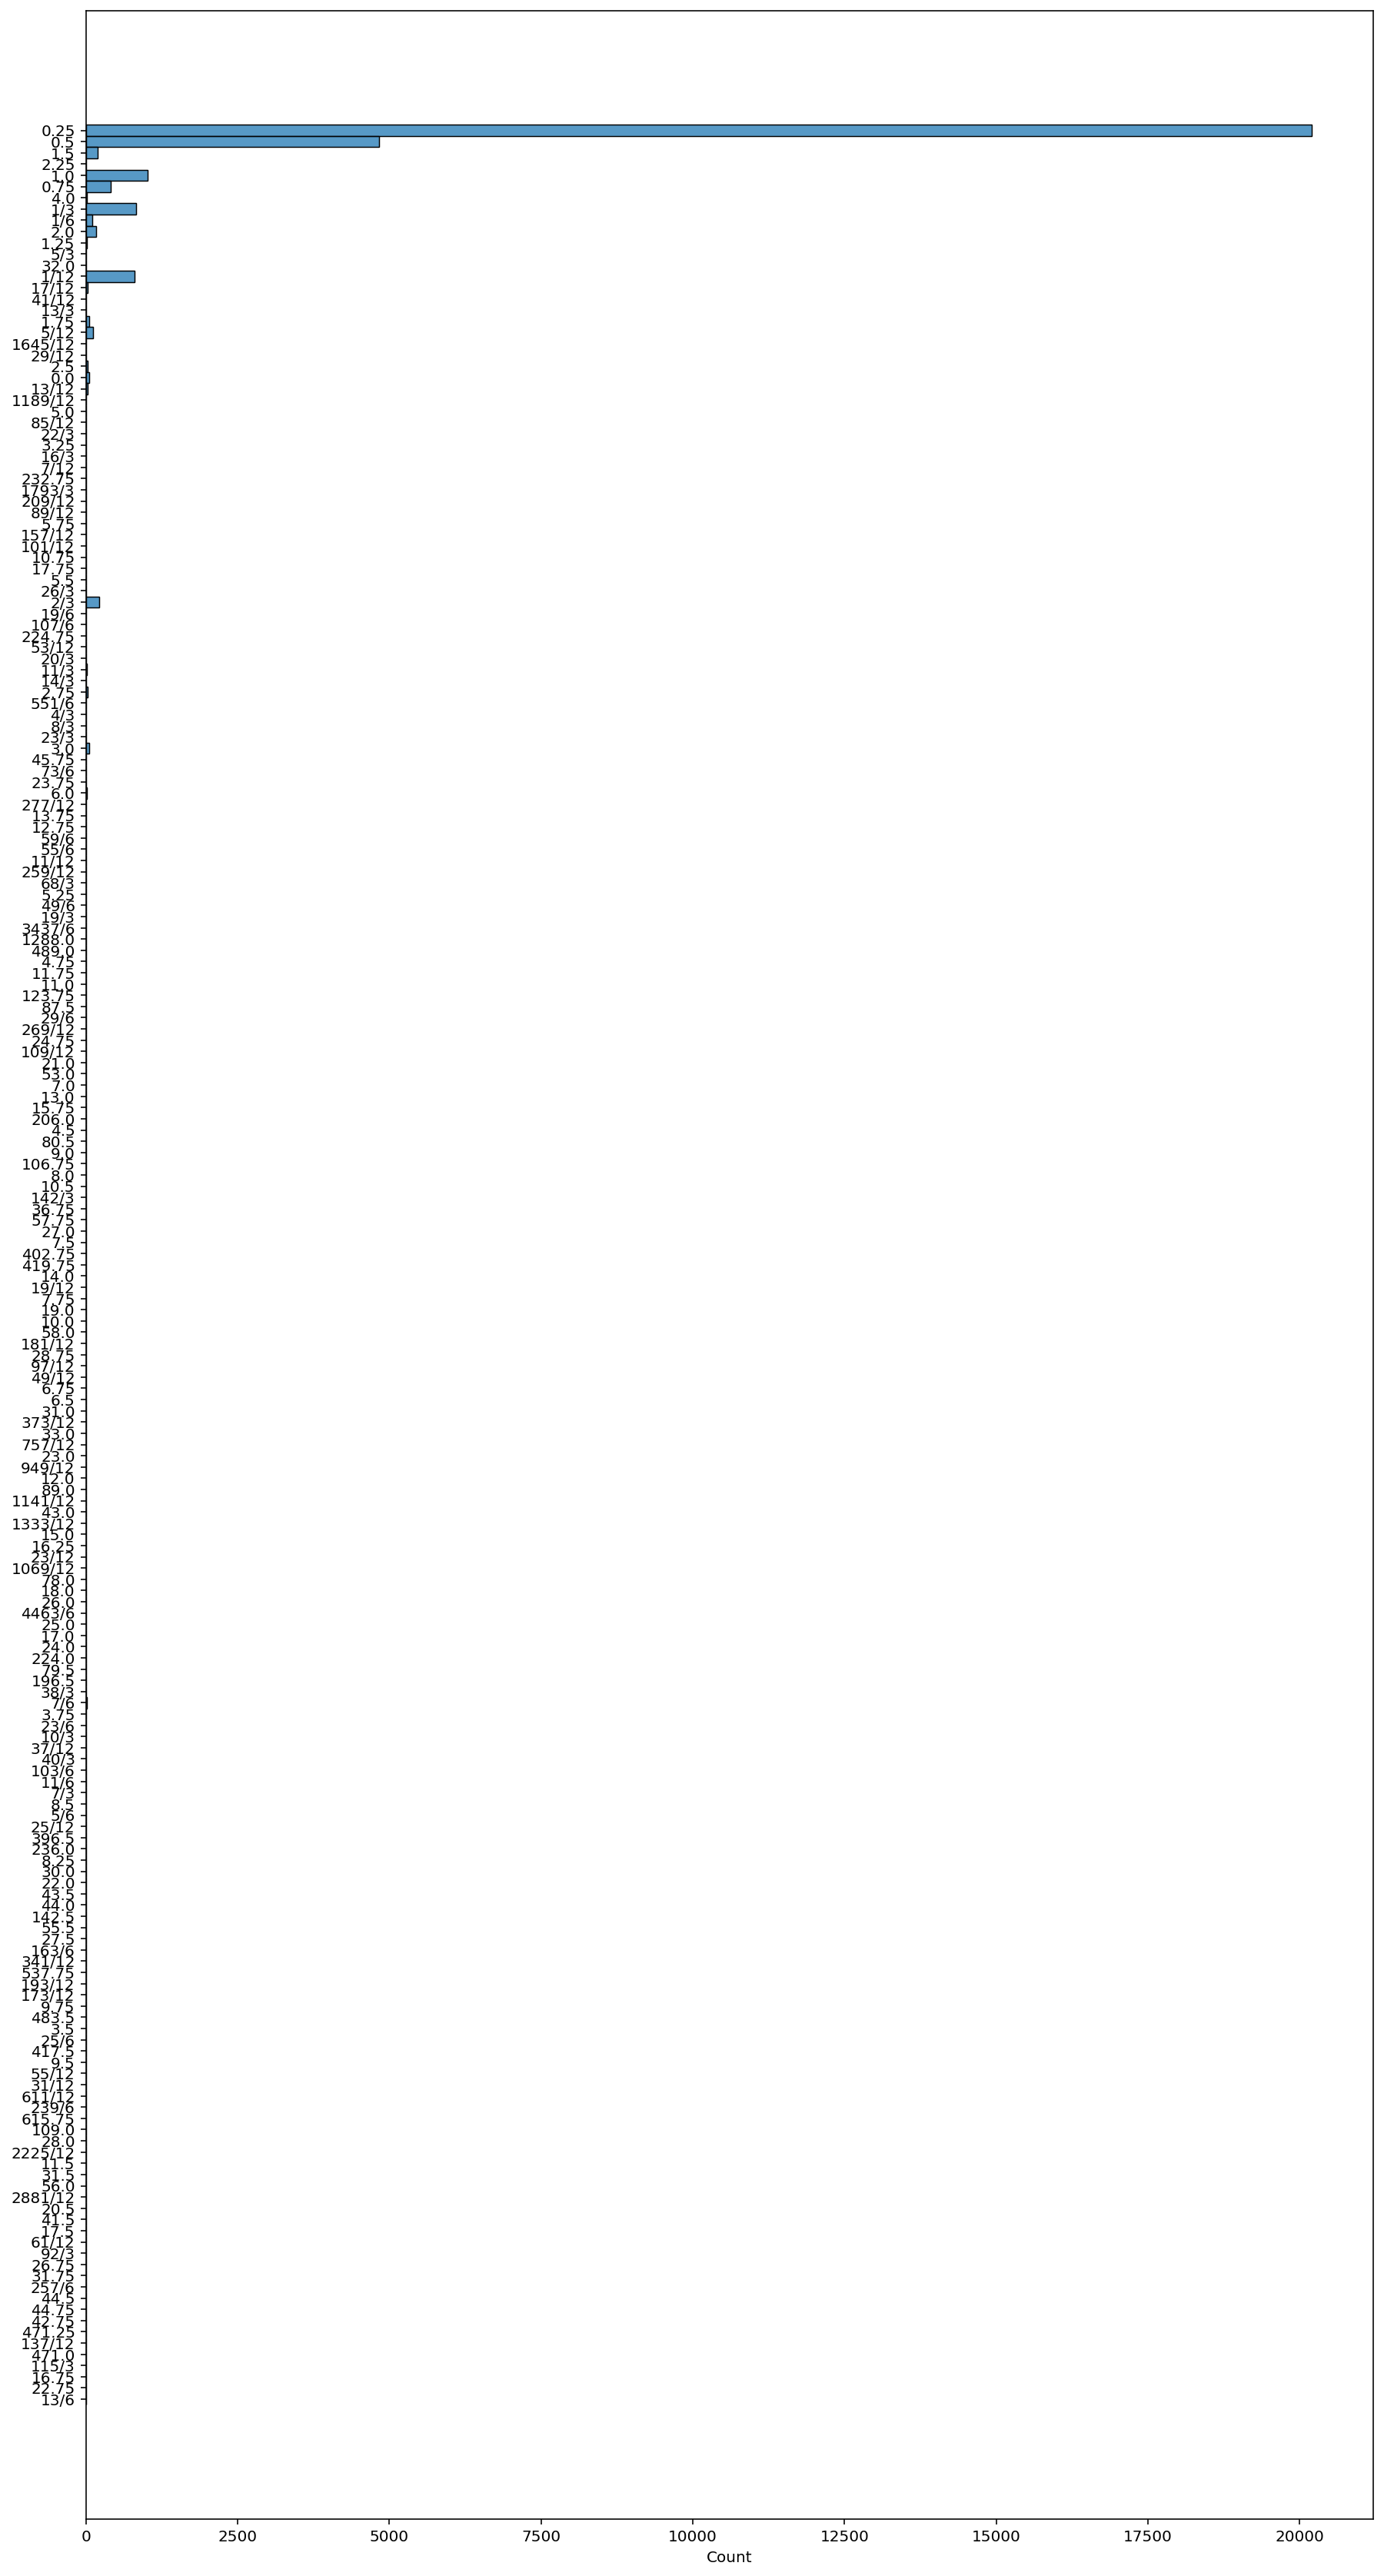

In [78]:
plt.figure(figsize=(15,30))
sns.histplot(y=[str(i) for i in all_durations])

In [112]:
(pd.Series(all_notes).value_counts() * 100 / len(all_notes))[:20]

rest    9.327212
A4      7.051953
E5      7.011444
D5      6.457820
C5      5.202039
B4      4.216318
A5      4.007022
G4      3.996894
E4      3.233974
E-5     3.183337
F5      3.088816
G5      3.028053
B-4     2.913277
F#5     2.882895
C#5     2.876144
F4      2.812004
D4      2.798501
G#5     2.511562
F#4     2.143605
B5      1.951187
dtype: float64

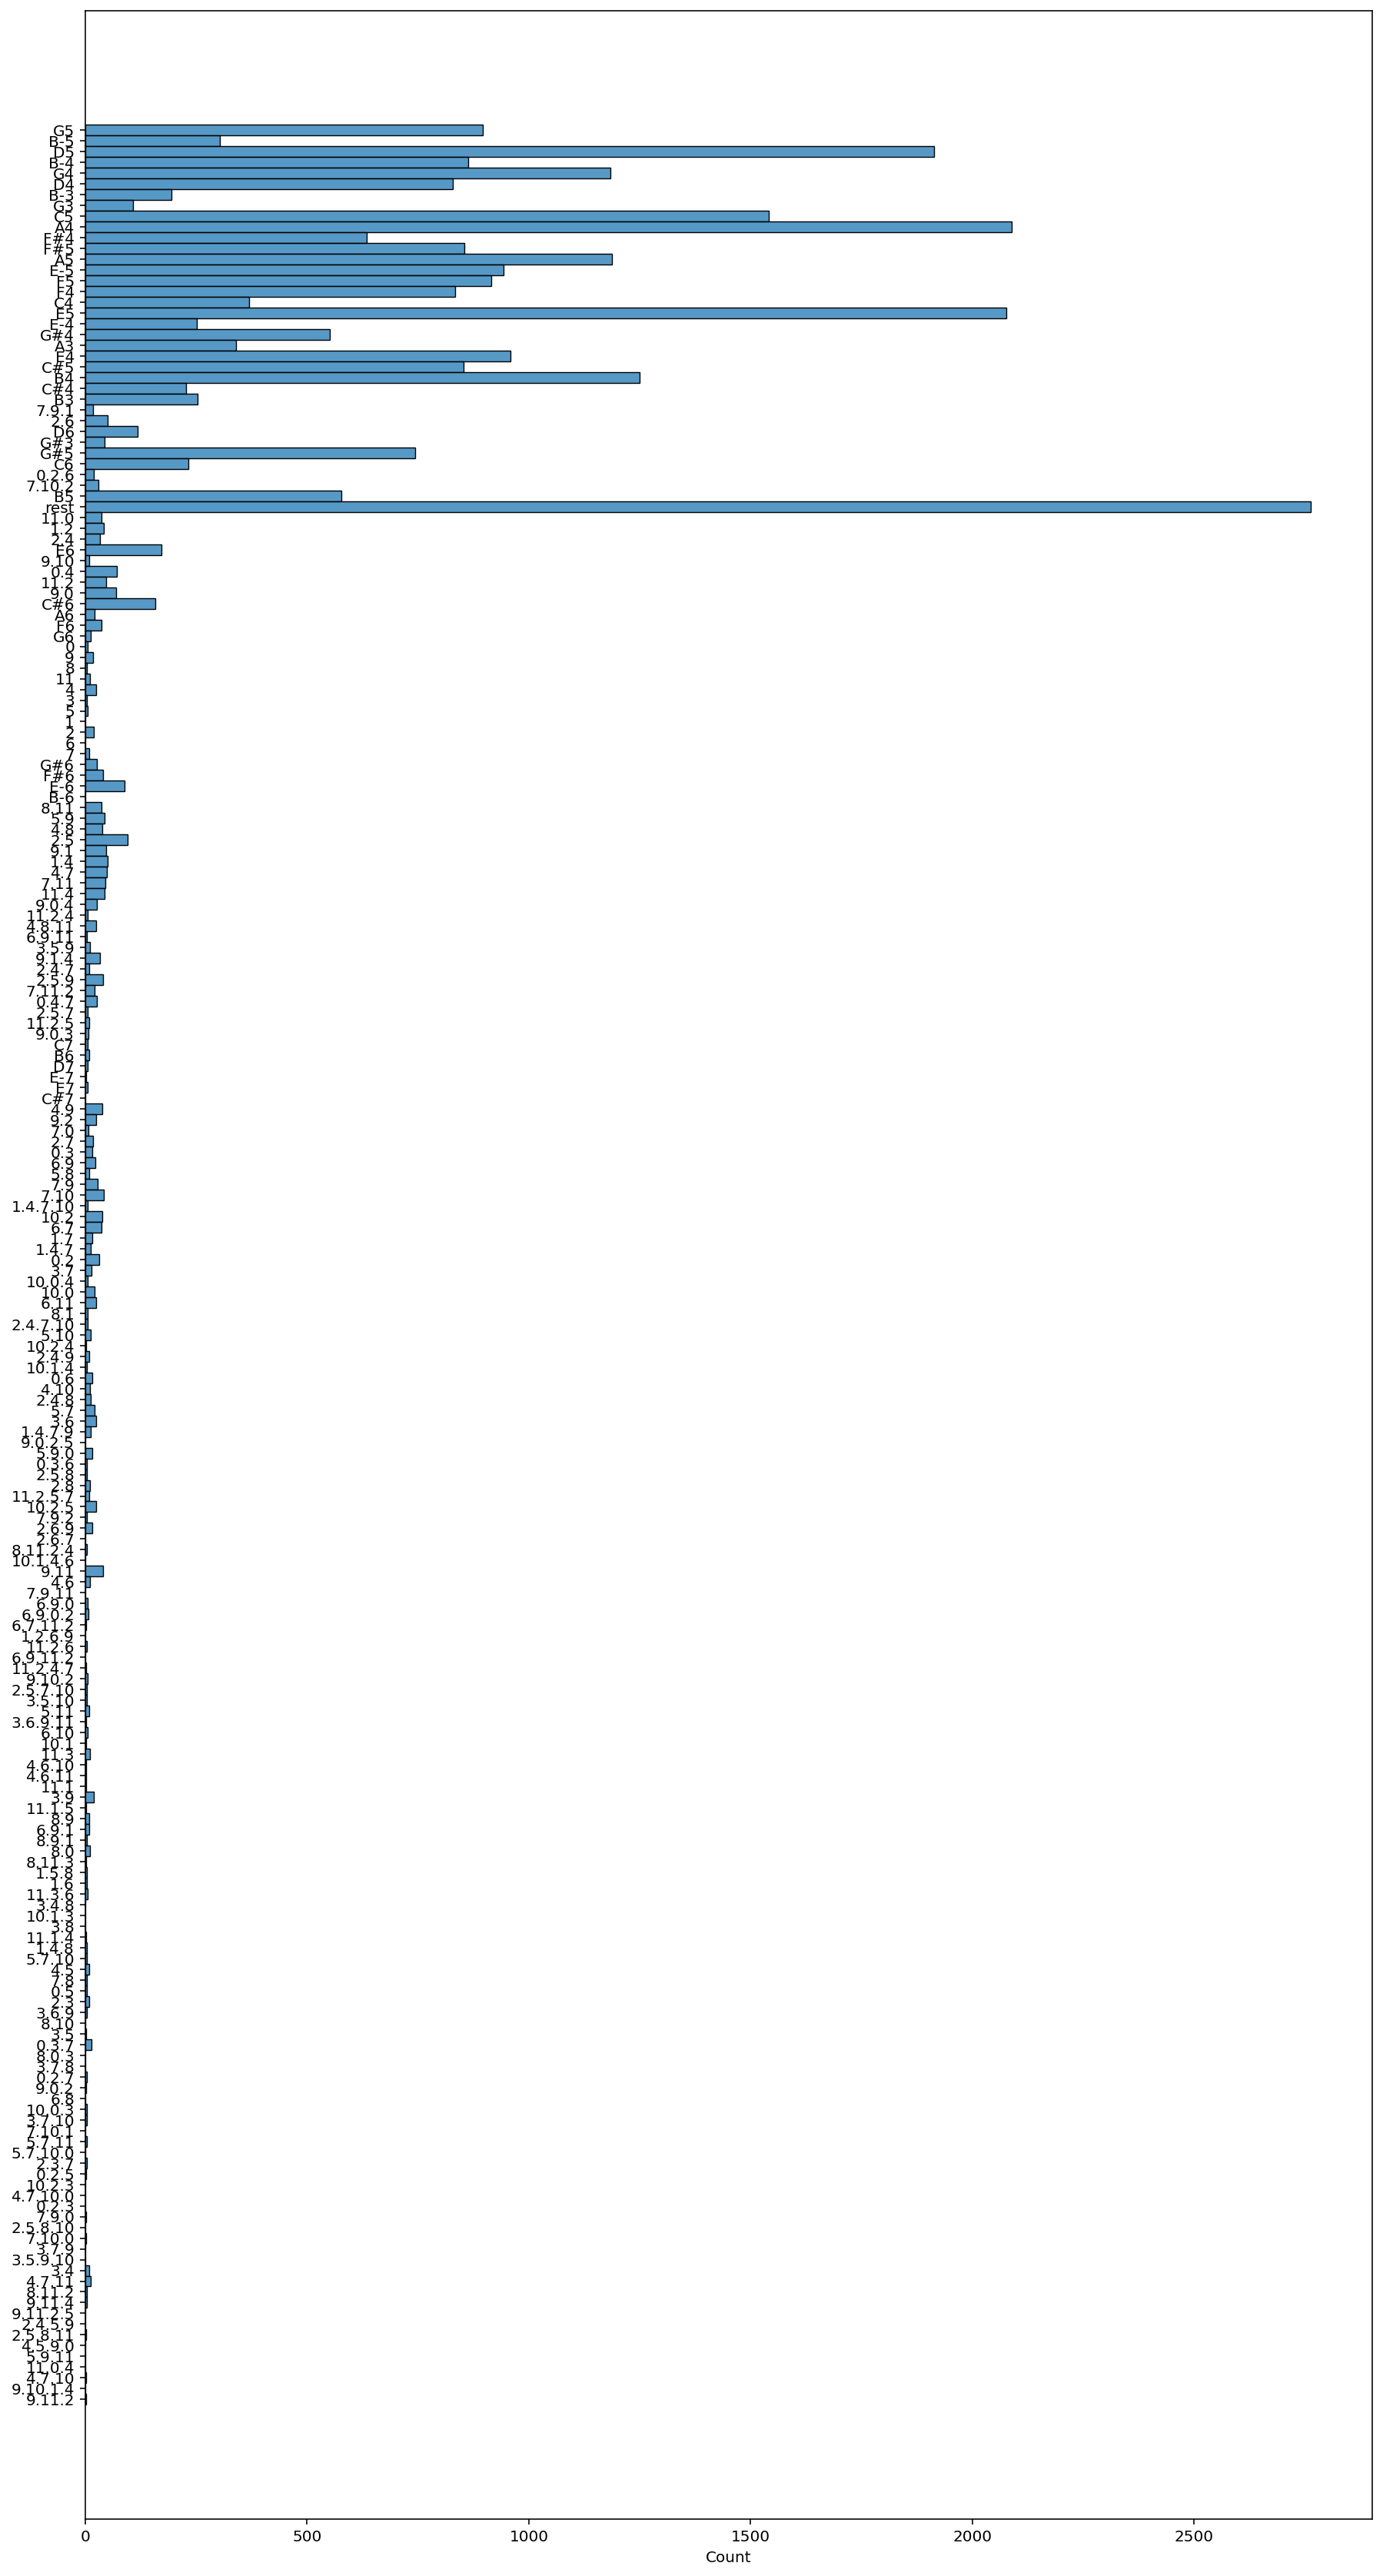

In [79]:
plt.figure(figsize=(15,30))
sns.histplot(y=all_notes)

In [80]:
num_to_notes = dict([i for i in enumerate(sorted(list(unique_notes)))])
notes_to_num = dict([reversed(i) for i in enumerate(sorted(list(unique_notes)))])

In [81]:
num_to_dur = dict([i for i in enumerate(sorted(list(unique_durations)))])
dur_to_num = dict([reversed(i) for i in enumerate(sorted(list(unique_durations)))])

In [82]:
num_to_off = dict([i for i in enumerate(sorted(list(unique_offsets)))])
off_to_num = dict([reversed(i) for i in enumerate(sorted(list(unique_offsets)))])

In [47]:
pickle.dump(num_to_notes, open('num_to_notes.pkl', 'wb'))
pickle.dump(num_to_dur, open('num_to_dur.pkl', 'wb'))
pickle.dump(num_to_off, open('num_to_off.pkl', 'wb'))

In [83]:
notes_full_map = [list(map(notes_to_num.get, i)) for i in notes_full]

In [84]:
durations_full_map = [list(map(dur_to_num.get, i)) for i in durations_full]

In [85]:
offsets_full_map = [list(map(off_to_num.get, i)) for i in offsets_full]

In [86]:
durations_full_map[0][:10]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [87]:
notes_full_map[0][:10]

[209, 171, 209, 186, 209, 186, 170, 186, 170, 208]

In [88]:
offsets_full_map[0][:10]

[0, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [93]:
full_data = [list(zip(notes_full_map[i], durations_full_map[i], offsets_full_map[i])) for i in range(len(notes_full_map))]

In [94]:
full_data[0][:10]

[(209, 3, 0),
 (171, 3, 3),
 (209, 3, 3),
 (186, 3, 3),
 (209, 3, 3),
 (186, 3, 3),
 (170, 3, 3),
 (186, 3, 3),
 (170, 3, 3),
 (208, 3, 3)]

In [95]:
def create_datasets(data, n_steps=100, batch_size=32, train_size=0.8):
    window_length = n_steps + 1
    datasets = []
    for j in [np.reshape(i, (-1, 1)) for i in data]:
        dataset = tf.data.Dataset.from_tensor_slices(j)
        dataset = dataset.window(window_length, shift=1, drop_remainder=True)
        dataset = dataset.flat_map(lambda window: window.batch(window_length))
        datasets.append(dataset)
        
    dataset_final = datasets[0]
    for k in datasets[1:]:
        dataset_final = dataset_final.concatenate(k)

    dataset_final = dataset_final.shuffle(10000).batch(batch_size)
    dataset_final = dataset_final.map(lambda window: (window[:, :-1], window[:, 1:]))
    
    train_size_batch = int(train_size * len(list(dataset_final)))

    train_set = dataset_final.take(train_size_batch)
    val_set = dataset_final.skip(train_size_batch)
    
    return train_set, val_set

In [96]:
train_set_notes, val_set_notes = create_datasets(notes_full_map)
train_set_dur, val_set_dur = create_datasets(durations_full_map)
train_set_off, val_set_off = create_datasets(offsets_full_map)

In [97]:
len(list(train_set_notes))

718

In [98]:
len(list(val_set_notes))

180

In [99]:
for X, y in train_set_notes.take(1):
    print(X.shape, y.shape)

(32, 100, 1) (32, 100, 1)


### Training

As we can see below, training for 15 epochs already gives roughly 97% accuracy for all of the models. However, when we look at the distributions of unique values which were shown above we can see that for durations and offsets distributions are highly skewed. Therefore the random guess will have more than 50% of chance to predict correct value and that is why we need a model which will have relatively high accuracy.

In [100]:
def train_model(n_embedding_dims=5, dataset_type=None, unique_values=None,
               train_set=None, val_set=None, epochs=5):
    if dataset_type == 'notes':
        model_name = 'notes_gen'
    if dataset_type == 'durations':
        model_name = 'durations_gen'
    if dataset_type == 'offsets':
        model_name = 'offsets_gen'
        
    model = keras.models.Sequential([
        keras.layers.Embedding(input_dim=len(unique_values), output_dim=n_embedding_dims,
                               input_shape=[None]),
        keras.layers.Conv1D(32, kernel_size=2, padding="causal", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(48, kernel_size=2, padding="causal", activation="relu", dilation_rate=2),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(64, kernel_size=2, padding="causal", activation="relu", dilation_rate=4),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(96, kernel_size=2, padding="causal", activation="relu", dilation_rate=8),
        keras.layers.BatchNormalization(),
        keras.layers.LSTM(256, return_sequences=True),
        keras.layers.Dense(len(unique_values), activation="softmax")
    ])

    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name + '.h5', save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   
    model.summary()
    history = model.fit(train_set, epochs=epochs, validation_data=val_set, callbacks=[checkpoint_cb, early_stopping])
    
    return history

In [39]:
train_model(dataset_type='notes', unique_values=unique_notes,
           train_set=train_set_notes, val_set=val_set_notes, epochs=15)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 5)           1060      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          352       
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 32)          128       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 48)          3120      
_________________________________________________________________
batch_normalization_13 (Batc (None, None, 48)          192       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 64)          6208      
_________________________________________________________________
batch_normalization_14 (Batc (None, None, 64)         

In [40]:
train_model(dataset_type='durations', unique_values=unique_durations,
           train_set=train_set_dur, val_set=val_set_dur, epochs=15)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 5)           1015      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 32)          352       
_________________________________________________________________
batch_normalization_16 (Batc (None, None, 32)          128       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 48)          3120      
_________________________________________________________________
batch_normalization_17 (Batc (None, None, 48)          192       
_________________________________________________________________
conv1d_18 (Conv1D)           (None, None, 64)          6208      
_________________________________________________________________
batch_normalization_18 (Batc (None, None, 64)         

In [41]:
train_model(dataset_type='offsets', unique_values=unique_offsets,
           train_set=train_set_off, val_set=val_set_off, epochs=15)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 5)           105       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, None, 32)          352       
_________________________________________________________________
batch_normalization_20 (Batc (None, None, 32)          128       
_________________________________________________________________
conv1d_21 (Conv1D)           (None, None, 48)          3120      
_________________________________________________________________
batch_normalization_21 (Batc (None, None, 48)          192       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, None, 64)          6208      
_________________________________________________________________
batch_normalization_22 (Batc (None, None, 64)         

In [48]:
model_notes = keras.models.load_model('notes_gen.h5')
model_durations = keras.models.load_model('durations_gen.h5')
model_offsets = keras.models.load_model('offsets_gen.h5')

### Predictions

In [115]:
def gen_pred(n_steps=10, full_data=None, temperature_note=1.0, temperature_dur=1.0, temperature_off=1.0):
    idx_0 = np.random.randint(0, len(full_data))
    idx_1 = np.random.randint(0, len(full_data[idx_0]))
    
    sample_notes_dur_off = full_data[idx_0][idx_1 : idx_1 + 5]
    sample_notes = np.array([i[0] for i in sample_notes_dur_off]).reshape(1, len(sample_notes_dur_off), 1)
    sample_dur = np.array([i[1] for i in sample_notes_dur_off]).reshape(1, len(sample_notes_dur_off), 1)
    sample_off = np.array([i[2] for i in sample_notes_dur_off]).reshape(1, len(sample_notes_dur_off), 1)
    
#     sample_notes = np.random.randint(0, len(unique_notes), (1, 3, 1))
#     sample_dur = np.random.randint(0, len(unique_durations), (1, 3, 1))
#     sample_off = np.random.randint(0, len(unique_offsets), (1, 3, 1))

#     for step in range(n_steps):
#         pred_note = np.argmax(model_notes.predict(sample_notes)[:, -1, :], axis=-1)
#         pred_dur = np.argmax(model_durations.predict(sample_dur)[:, -1, :], axis=-1)
#         pred_off = np.argmax(model_offsets.predict(sample_off)[:, -1, :], axis=-1)

#         sample_notes = np.concatenate([sample_notes, pred_note.reshape(1, 1, 1)], axis=1)
#         sample_dur = np.concatenate([sample_dur, pred_dur.reshape(1, 1, 1)], axis=1)
#         sample_off = np.concatenate([sample_off, pred_off.reshape(1, 1, 1)], axis=1)

    
    for step in range(n_steps):
        logits_notes = model_notes.predict(sample_notes)[:, -1, :]
        logits_dur = model_durations.predict(sample_dur)[:, -1, :]
        logits_off = model_offsets.predict(sample_off)[:, -1, :]
        
        next_note = np.array(tf.random.categorical(tf.math.log(logits_notes) / temperature_note, num_samples=1))[0].reshape(1, 1, 1)
        next_dur = np.array(tf.random.categorical(tf.math.log(logits_dur) / temperature_dur, num_samples=1))[0].reshape(1, 1, 1)
        next_off = np.array(tf.random.categorical(tf.math.log(logits_off) / temperature_off, num_samples=1))[0].reshape(1, 1, 1)
        
        sample_notes = np.concatenate([sample_notes, next_note], axis=1)
        sample_dur = np.concatenate([sample_dur, next_dur], axis=1)
        sample_off = np.concatenate([sample_off, next_off], axis=1)
    
    sample_notes_mapped = list(map(num_to_notes.get, list(sample_notes.reshape(-1))))
    sample_dur_mapped = list(map(num_to_dur.get, list(sample_dur.reshape(-1))))
    sample_off_mapped = list(map(num_to_off.get, list(sample_off.reshape(-1))))
    
    return sample_notes_mapped, sample_dur_mapped, sample_off_mapped 

In [208]:
def gen_midi(pred):
    pred_notes, pred_dur, pred_off = pred
    offset = Fraction(0.0)
    output_notes = []
    for pattern, dur, off in zip(pred_notes, pred_dur, pred_off):
        if ('.' in pattern) or pattern.isdigit():
            offset += Fraction(off)
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            new_chord.duration = duration.Duration(dur)
            output_notes.append(new_chord)
        elif pattern == 'rest':
            offset += Fraction(off)
            new_note = note.Rest(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            new_note.duration = duration.Duration(dur)
            output_notes.append(new_note)
        else:
            offset += Fraction(off)
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            new_note.duration = duration.Duration(dur)
            output_notes.append(new_note)
    
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='gen_music.mid')
    midi_stream.show('midi')

In [209]:
preds = gen_pred(n_steps=20, full_data=full_data, temperature_note=1.0, temperature_dur=1.0, temperature_off=1.0)
gen_midi(preds)

In [201]:
preds

(['6.7',
  '9.0',
  'rest',
  '2.3',
  '0.2',
  '1.4.7',
  'D4',
  '5.9.0',
  'A3',
  'A3',
  '2.4',
  '11.2.5',
  '7.10',
  'C#4',
  '11.2',
  'A5',
  '2.5',
  '2.8',
  'A3',
  'A5',
  'D5',
  'C#5',
  'D5',
  'E5',
  'D5'],
 [0.25,
  0.25,
  Fraction(1, 12),
  0.25,
  0.25,
  Fraction(1, 12),
  0.25,
  0.25,
  0.25,
  Fraction(49, 12),
  1.5,
  7.0,
  0.5,
  1.0,
  1.0,
  0.5,
  1.0,
  1.0,
  1.0,
  0.5,
  1.0,
  2.0,
  0.25,
  0.25,
  0.25],
 [Fraction(1, 6),
  Fraction(1, 12),
  Fraction(1, 6),
  Fraction(1, 12),
  Fraction(0, 1),
  Fraction(1, 4),
  Fraction(0, 1),
  Fraction(1, 4),
  Fraction(1, 12),
  Fraction(1, 6),
  Fraction(1, 6),
  Fraction(1, 12),
  Fraction(0, 1),
  Fraction(1, 4),
  Fraction(0, 1),
  Fraction(1, 4),
  Fraction(1, 12),
  Fraction(1, 6),
  Fraction(1, 6),
  Fraction(1, 12),
  Fraction(0, 1),
  Fraction(0, 1),
  Fraction(1, 4),
  Fraction(1, 4),
  Fraction(1, 4)])